# Smooth edges for SkyDisk and SkyEllipse models

As we don't integrate of the spatial pixels for the model evaluation, the sharp edges of the `SkyEllipse` as well as `SkyDisk` models lead to fit convergence problems (see https://github.com/gammapy/gammapy/issues/2109). This notebooks explores the possibility of implementing "smooth" edges for those models. This is realized by using `scipy.special.erf` instead of a hard criterion, whether the coordinate is inside or outside the disk / ellipse.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyEllipse
from gammapy.cube.models import SkyModel
from gammapy.cube import simulate_dataset
from gammapy.utils.fitting import Fit

In [3]:
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)

In [4]:
# Define sky model to simulate the data
spatial_model = SkyEllipse(lon_0="0.1 deg", lat_0="0.1 deg", semi_major="0.2 deg", e=0.7, theta="30 deg", edge="0.04 deg")

spectral_model = PowerLaw(
    index=2,
    amplitude="1e-12 cm-2 s-1 TeV-1",
    reference="1 TeV",
)

sky_model_simu = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)
print(sky_model_simu)

SkyModel

Parameters: 

	   name      value   error      unit         min        max    frozen
	---------- --------- ----- -------------- ---------- --------- ------
	     lon_0 1.000e-01   nan            deg -1.800e+02 1.800e+02  False
	     lat_0 1.000e-01   nan            deg -9.000e+01 9.000e+01  False
	semi_major 2.000e-01   nan            deg        nan       nan  False
	         e 7.000e-01   nan                 0.000e+00 1.000e+00  False
	     theta 3.000e+01   nan            deg        nan       nan  False
	      edge 4.000e-02   nan            deg  1.000e-02       nan   True
	     index 2.000e+00   nan                       nan       nan  False
	 amplitude 1.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
	 reference 1.000e+00   nan            TeV        nan       nan   True


In [5]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1, 2, 30), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

# Define some observation parameters
pointing = SkyCoord(0 * u.deg, 0 * u.deg, frame="galactic")


dataset = simulate_dataset(
    sky_model_simu, geom, pointing, irfs, livetime=5 * u.h, random_state=42
)

In [6]:
flux = dataset._evaluators[0].compute_flux()

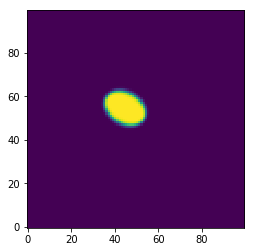

In [7]:
plt.imshow(flux.value[0], origin="lower")

In [8]:
npred = dataset.npred()

In [9]:
npred.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [10]:
fit = Fit([dataset])
fit.datasets.parameters.apply_autoscale = False
fit.datasets.parameters.covariance = np.diag([0.01, 0.01, 0.01, 0.01, 1, 0.01, 0.01, 1e-14, 0.1, 0.1, 0.01, 0.1]) ** 2

In [11]:
%%time
result = fit.run()

CPU times: user 15.6 s, sys: 326 ms, total: 15.9 s
Wall time: 8 s


In [12]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	nfev       : 144
	total stat : 159565.53
	message    : Optimization terminated successfully.



### Longitude likelihood profile

In [13]:
p = fit.likelihood_profile(parameter="lon_0", values=np.linspace(0.095, 0.105, 21))

Text(0, 0.5, 'Delta TS')

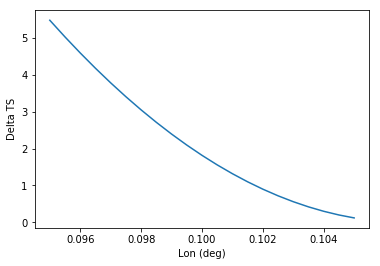

In [14]:
plt.plot(p["values"], p["likelihood"] - result.total_stat)
plt.xlabel("Lon (deg)")
plt.ylabel("Delta TS")

### Latitude likelihood profile

In [15]:
p = fit.likelihood_profile(parameter="lat_0", values=np.linspace(0.095, 0.105, 21))

Text(0, 0.5, 'Delta TS')

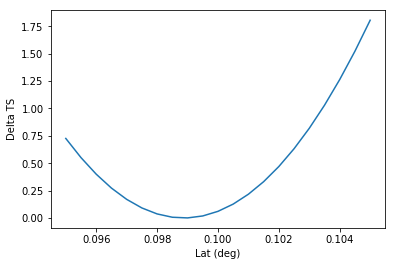

In [16]:
plt.plot(p["values"], p["likelihood"] - result.total_stat)
plt.xlabel("Lat (deg)")
plt.ylabel("Delta TS")

### Semi major likelihood profile

In [17]:
p = fit.likelihood_profile(parameter="semi_major", values=np.linspace(0.195, 0.205, 21))

Text(0, 0.5, 'Delta TS')

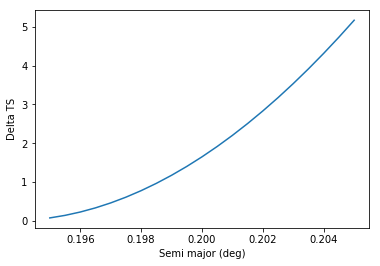

In [18]:
plt.plot(p["values"], p["likelihood"] - result.total_stat)
plt.xlabel("Semi major (deg)")
plt.ylabel("Delta TS")